In [1]:
import os
import json
import itertools
import matplotlib.pyplot as plt

import pandas as pd
from haystack.nodes import TfidfRetriever
from haystack.document_stores import InMemoryDocumentStore
from haystack.schema import Document
from haystack.nodes import PreProcessor

/home/adi/anaconda3/envs/py382/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO - haystack.document_stores.base -  Numba not found, replacing njit() with no-op implementation. Enable it with 'pip install numba'.
INFO - haystack.modeling.model.optimization -  apex not found, won't use it. See https://nvidia.github.io/apex/


In [2]:
#we define the tests parameters - here is the only cell where we need to give our input

input_file_name = "10.json"

split_length = 100
tokenizer_model = None
use_gpu = False

Readers = [
           "FARMReader" 
          ,"TransformersReader"
]

reference_test_id = ("FARMReader", "deepset/roberta-base-squad2", (10,3))

Language_Models = [
                   "deepset/minilm-uncased-squad2"
#                  ,"deepset/roberta-base-squad2-distilled"
#                  ,"deepset/roberta-base-squad2"
#                  ,"deepset/electra-base-squad2"
#                  ,"deepset/tinyroberta-6l-768d"
#                  ,"distilbert-base-uncased-distilled-squad"
#                  ,"distilbert-base-uncased"
#                  ,"deepset/bert-base-cased-squad2"
#                  ,"deepset/electra-base-squad2"
#                  ,"distilbert-base-uncased-finetuned-sst-2-english"
]

topK_Retriever_Reader_Scenarios = [
                                   (10,3)
#                                  ,(10,5)
]

In [3]:
Tests = list(itertools.product(Readers, Language_Models, topK_Retriever_Reader_Scenarios))

In [4]:
preprocessor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="word",
    split_length=split_length,
    split_respect_sentence_boundary=True,
)

In [5]:
def read_file(path):
    with open(path) as f:
        j = json.load(f)
        return j

In [6]:
def file_to_doc(path, preprocessor):
    data = read_file(path)
    docs = [Document(content=t).to_dict() for t in data['texts']]

    return preprocessor.process(docs)

In [7]:
def file_to_docstore(name):
    document_store = InMemoryDocumentStore()
    
    fpath = f'./data/{name}'
    docs = []
    adi_counter = 0
    for d in file_to_doc(fpath, preprocessor):
        
        adi_counter = adi_counter + 1
        
        d['id'] = f"{d['id']}-{d['meta']['_split_id']}"
        
        docs.append(d)
            
    print(f"{len(docs)} documents found")
    data = read_file(fpath)
    
    document_store.write_documents(docs)
    retriever = TfidfRetriever(document_store=document_store)
    
    return document_store, retriever, data['query']

In [8]:
def get_scores(prediction):
    scores = ["{:.3f}".format(a.score) for a in prediction['answers']]
    answers = [a.answer for a in prediction['answers']]
    df = pd.DataFrame(dict(scores=scores, answers=answers))
    
    return df           

In [9]:
document_store, retriever, query = file_to_docstore(input_file_name)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 608.16docs/s]
INFO - haystack.nodes.retriever.sparse -  Found 4 candidate paragraphs from 4 docs in DB


4 documents found


In [10]:
def get_parameters_from_test_id(test_id):
    #test_id is a tuple with 3 elements:
    #test_id[0] = Reader
    #test_id[1] = Language_Model
    #test_id[2] = topK_Retriever_Reader_Scenario
    #e.g. ("FARMReader", "deepset/minilm-uncased-squad2", (10,3))
    
    test_Reader = test_id[0]
    test_Language_Model = test_id[1]
    test_topK_Retriever_Reader_Scenario = test_id[2]
    
    return test_Reader, test_Language_Model, test_topK_Retriever_Reader_Scenario            

In [11]:
def get_test_topK_Retriever_from_test_id(test_id):
    
    return test_id[2][0]                

In [12]:
def get_test_topK_Reader_from_test_id(test_id):
    
    return test_id[2][1]      

In [13]:
def get_reader_from_test_id(test_id):
    test_Reader, test_Language_Model, test_topK_Retriever_Reader_Scenario = get_parameters_from_test_id(test_id)
    
    reader = ""
    
    if (test_Reader == "FARMReader"):
        reader = FARMReader(model_name_or_path=test_Language_Model, use_gpu=use_gpu)
        
    if (test_Reader == "TransformersReader"):
        reader = TransformersReader(model_name_or_path=test_Language_Model, tokenizer=tokenizer_model, use_gpu=use_gpu)
        
    return reader

In [14]:
def get_predictions_comparison_score_for_same_length_df(refference_df, compared_df):
    
    prediction_comparison_score = 0
    
    #we create a set out of each data frame elements from the column "answers"
    
    refference_df_set = set(refference_df["answers"])
    compared_df_set = set(compared_df["answers"])
    
    #we will do an union of the two sets, and we will allocate the score of 0.5 * [cardinal(union_set) - ((cardinal(refference_df_set) + cardinal(compared_df_set))]
    #then we will compare the elements position by position and for each coincidence we will add 0.5 to the prediction_comparison_score
    
    intersection_set = refference_df_set.intersection(compared_df_set)
    
    prediction_comparison_score = 0.5 * len(intersection_set)
    
    for i in range(len(compared_df)):
        compared_string = str(compared_df["answers"][i])
        reference_string = str(refference_df["answers"][i])

        if (compared_string.strip() == reference_string.strip()):
            prediction_comparison_score += 0.5
        
    return prediction_comparison_score

In [15]:
def get_predictions_comparison_score(refference_df, compared_df):
    
    prediction_comparison_score = 0

    refference_df_number_of_elements = refference_df.shape[0]
    compared_df_number_of_elements = compared_df.shape[0]
    
    if (compared_df_number_of_elements != refference_df_number_of_elements):
        min_number_of_df_elements = min(refference_df_number_of_elements, compared_df_number_of_elements)
        
        adjusted_refference_df = refference_df.heaf(min_number_of_df_elements)
        adjusted_compared_df = compared_df.head(min_number_of_df_elements)
        
        prediction_comparison_score = get_predictions_comparison_score_for_same_length_df(adjusted_refference_df, adjusted_compared_df)
    else:
        prediction_comparison_score = get_predictions_comparison_score_for_same_length_df(refference_df, compared_df)
    
    return prediction_comparison_score

In [16]:
def execute_test(test_id):
    
    reader = get_reader_from_test_id(test_id)
    
    top_k_Retriever = get_test_topK_Retriever_from_test_id(test_id)
    top_k_Reader = get_test_topK_Reader_from_test_id(test_id)
    
    pipe = ExtractiveQAPipeline(reader, retriever)
    
    start = time.time()
    prediction = pipe.run(query=query, params={"Retriever": {"top_k": top_k_Retriever}, "Reader": {"top_k": top_k_Reader}})
    end = time.time()
    
    total_time = end - start
    
    test_Reader, test_Language_Model, test_topK_Retriever_Reader_Scenario = get_parameters_from_test_id(test_id)
    
    predictions_df = get_scores(prediction)
    
    del pipe
    pipe = None
    
    del reader
    reader = None

    return predictions_df, total_time
        

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/roberta-base-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/roberta-base-squad2
INFO - haystack.modeling.logger -  ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.infer -  Got ya 11 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0     0     0     0     0     0     0     0     0     0  
INFO - haystack.modeling.infer -  /w\   /w\   /w\   /w\   /w\ 

This is the results dataframe:
                                                                  Speed  \
(FARMReader, deepset/minilm-uncased-squad2, (10, 3))          13.851422   
(TransformersReader, deepset/minilm-uncased-squad2, (10, 3))  13.568477   

                                                             Accuracy  \
(FARMReader, deepset/minilm-uncased-squad2, (10, 3))              1.0   
(TransformersReader, deepset/minilm-uncased-squad2, (10, 3))      0.5   

                                                              Ref_Reader  \
(FARMReader, deepset/minilm-uncased-squad2, (10, 3))          FARMReader   
(TransformersReader, deepset/minilm-uncased-squad2, (10, 3))  FARMReader   

                                                                        Ref_LanguageModel  \
(FARMReader, deepset/minilm-uncased-squad2, (10, 3))          deepset/roberta-base-squad2   
(TransformersReader, deepset/minilm-uncased-squad2, (10, 3))  deepset/roberta-base-squad2   

              

/home/adi/anaconda3/envs/py382/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


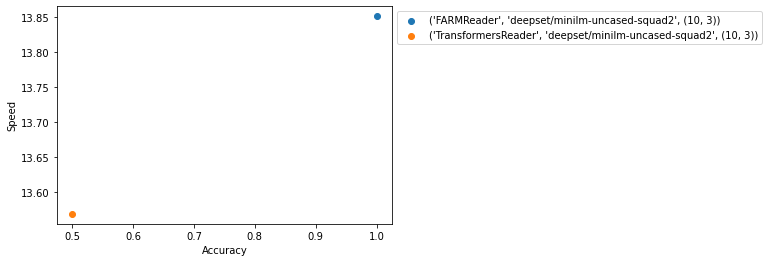

For reference, please see below the answers and the speed per each test.
The reference test answers: 
  scores                         answers
0  0.813                   On the server
1  0.667  EEA greenhouse gas data viewer
2  0.599                   on the server
test is: ==> ('FARMReader', 'deepset/minilm-uncased-squad2', (10, 3)) <==
answers are:   scores                         answers
0  0.774  EEA greenhouse gas data viewer
1  0.705                   On the server
2  0.598                          server
speed is: 0.30806541442871094
test is: ==> ('TransformersReader', 'deepset/minilm-uncased-squad2', (10, 3)) <==
answers are:   scores                         answers
0  0.582  EEA greenhouse gas data viewer
1  0.519                                
2  0.474                          server
speed is: 0.06696462631225586

Done


In [17]:
#here we execute all the tests

import time
from haystack.pipelines import ExtractiveQAPipeline
from haystack.nodes import FARMReader, TransformersReader


dict__test_id__prediction_df = {}
dict__test_id__speed = {}



results_df_columns = ["Speed", "Accuracy", "Ref_Reader", "Ref_LanguageModel", "Ref_topK_Retriever", "Ref_topK_Reader"]

results_df_rows = []

for test in Tests:
    results_df_rows.append(test)

reference_test_start_time = time.time()
reference_answers_df, reference_speed_df = execute_test(reference_test_id)
reference_test_end_time = time.time()

reference_test_time = reference_test_end_time - reference_test_start_time


results_df = pd.DataFrame(columns=results_df_columns, index=results_df_rows)

for test in Tests:
    if (test != reference_test_id):
        start = time.time()
        dict__test_id__prediction_df[test], dict__test_id__speed[test]  = execute_test(test)
        end = time.time()
        results_df.at[test,"Speed"] = end - start
    else:
        dict__test_id__prediction_df[test], dict__test_id__speed[test] = reference_answers_df, reference_speed_df
        results_df.at[test,"Speed"] = reference_test_time
    
    accuracy_score = get_predictions_comparison_score(dict__test_id__prediction_df[test], reference_answers_df)
    
    results_df.at[test,"Accuracy"] = accuracy_score
    results_df.at[test,"Ref_Reader"] = reference_test_id[0]
    results_df.at[test,"Ref_LanguageModel"] = reference_test_id[1]
    results_df.at[test,"Ref_topK_Retriever"] = reference_test_id[2][0]
    results_df.at[test,"Ref_topK_Reader"] = reference_test_id[2][1]
    


print("This is the results dataframe:")
print(results_df)


print("Please see below the scatter chart having as points the tests, on X axis the Accuracy and on Y axis the Speed.")

for ticker,row in results_df.iterrows():
    plt.scatter(row['Accuracy'], row['Speed'], label=ticker)

plt.xlabel('Accuracy')
plt.ylabel('Speed')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

print("For reference, please see below the answers and the speed per each test.")

print("The reference test answers: ")
print(reference_answers_df)
      
for test in Tests:      
    print("test is: ==> " + str(test) + " <==")
    print("answers are: " + str(dict__test_id__prediction_df[test]))
    print("speed is: " + str(dict__test_id__speed[test]))

      
print("\nDone")

del dict__test_id__prediction_df
dict__test_id__prediction_df = None

del dict__test_id__speed
dict__test_id__speed = None